In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
import utils.anova_utils as anova_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

from tqdm import tqdm

In [2]:
# pass in time bins we'd like to analyze

# per feature, grab sessions that satisfy
# when loading beh, grab next trial number with shift

# neural activity of next trial number, current trial number
# compute projection per trial (averaged across time bins)


In [3]:
# need to go in direction of high not X to high X
high_idx = MODE_TO_CLASSES["pref"].index("High X")
low_idx = MODE_TO_CLASSES["pref"].index("High Not X")

def load_pref_vector(args):
    models = belief_partitions_io.read_models(args, [args.feat])
    unit_ids = belief_partitions_io.read_units(args, [args.feat])
    models["weightsdiff"] = models.apply(lambda x: x.models.coef_[high_idx, :] - x.models.coef_[low_idx, :], axis=1)
    models["batch_mean"] = models.apply(lambda x: x.models.model.norm.running_mean.detach().cpu().numpy(), axis=1)
    models["batch_std"] = models.apply(lambda x: np.sqrt(x.models.model.norm.running_var.detach().cpu().numpy() + 1e-5), axis=1)

    def avg_and_label(x):
        weights_diff_means = np.mean(np.vstack(x.weightsdiff.values), axis=0)
        mean_means = np.mean(np.vstack(x.batch_mean.values), axis=0)
        std_means = np.mean(np.vstack(x.batch_std.values), axis=0)
        pos = np.arange(len(weights_diff_means))
        
        return pd.DataFrame({"pos": pos, "weightsdiff": weights_diff_means, "mean": mean_means, "std": std_means})
    weights = models.groupby(["Time", "feat"]).apply(avg_and_label).reset_index()
    weights = pd.merge(weights, unit_ids, on=["feat", "pos"])
    # weights times are right aligned, but firing rates are left-aligned... 
    # at some point need to reconcile the two
    weights["TimeIdx"] = ((weights["Time"] - 0.1) * 10).round().astype(int)
    return weights

def get_proj_pseudo_for_session(session, args, num_pseudo=1000):
    beh = behavioral_utils.load_behavior_from_args(session, args)
    beh["NextTrialNumber"] = beh.shift(-1).TrialNumber
    beh = beh[~beh.NextTrialNumber.isna()]
    beh["NextTrialNumber"] = beh.NextTrialNumber.astype(int)
    beh = behavioral_utils.get_feat_choice_label(beh, args.feat)
    beh = behavioral_utils.get_belief_partitions(beh, args.feat, use_x=True)

    beh = behavioral_utils.filter_behavior(beh, args.conditions)

    frs = spike_utils.get_frs_from_args(args, session)
    frs["TimeIdx"] = (frs["Time"] * 10).round().astype(int)
    fr_w_next = pd.merge(frs, beh[["TrialNumber", "NextTrialNumber"]], on="TrialNumber")
    fr_w_next = pd.merge(fr_w_next, frs, left_on=["NextTrialNumber", "PseudoUnitID", "TimeIdx"], right_on=["TrialNumber", "PseudoUnitID", "TimeIdx"], suffixes=[None, "Next"])
    fr_w_next["FiringRateDiff"] = fr_w_next["FiringRateNext"] - fr_w_next["FiringRate"]
    fr_diffs = fr_w_next[["TrialNumber", "PseudoUnitID", "TimeIdx", "FiringRateDiff"]]


    model_args = copy.deepcopy(args)
    # ensure models are not from shuffles
    model_args.shuffle_idx = None
    weights = load_pref_vector(model_args)
    proj = pd.merge(fr_diffs, weights, on=["PseudoUnitID", "TimeIdx"])

    def compute_dot(group):
        # currently using variance found from batch norm layer
        return (group.FiringRateDiff / group["std"] * group.weightsdiff).sum()

    proj = proj.groupby(["TimeIdx", "TrialNumber"]).apply(compute_dot).reset_index(name="proj")
    rng = np.random.default_rng()
    trial_nums = rng.choice(proj.TrialNumber.unique(), num_pseudo)
    pseudo_trials = pd.DataFrame({"TrialNumber": trial_nums, "PseudoTrialNumber": list(range(num_pseudo))})
    proj_pseudo = pd.merge(proj, pseudo_trials, on="TrialNumber")
    proj_pseudo["session"] = session

    return proj_pseudo

def proj_all_sessions(args, sessions): 
    res = []
    for session in tqdm(sessions):
        res.append(get_proj_pseudo_for_session(session, args))
    res = pd.concat(res)
    summed_proj = res.groupby(["TimeIdx", "PseudoTrialNumber"]).proj.sum().reset_index(name="proj")
    return summed_proj

In [6]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.subject = "SA"
args.sig_unit_level = "pref_99th_window_filter_drift"

# args.conditions = {"Response": "Correct", "Choice": "Chose", "BeliefPartition": "Low"}
# args.conditions = {"Response": "Incorrect", "Choice": "Chose", "BeliefPartition": "High X"}
# args.conditions = {"Response": "Incorrect", "Choice": "Chose"}
args.conditions = {"Response": "Correct", "Choice": "Chose"}

args.mode = "pref"
args.trial_interval = get_trial_interval(args.trial_event)

feats = pd.read_pickle(FEATS_PATH.format(sub="SA"))
valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=args.subject))

row = feats.iloc[1]
args.feat = row.feat

summed_proj = proj_all_sessions(args, row.sessions)

args.shuffle_idx = 1
args.all_sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
shuffled_proj = proj_all_sessions(args, row.sessions)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Session permutation shuffle set, randomly choosing from 21 other sessions


  5%|▍         | 1/22 [00:00<00:11,  1.75it/s]

Session permutation shuffle set, randomly choosing from 21 other sessions


  9%|▉         | 2/22 [00:01<00:15,  1.29it/s]

Session permutation shuffle set, randomly choosing from 21 other sessions


 14%|█▎        | 3/22 [00:02<00:15,  1.23it/s]

Session permutation shuffle set, randomly choosing from 21 other sessions


 18%|█▊        | 4/22 [00:03<00:19,  1.08s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 23%|██▎       | 5/22 [00:05<00:19,  1.13s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 27%|██▋       | 6/22 [00:06<00:17,  1.10s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 32%|███▏      | 7/22 [00:07<00:16,  1.10s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 36%|███▋      | 8/22 [00:08<00:14,  1.02s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 41%|████      | 9/22 [00:09<00:13,  1.06s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 45%|████▌     | 10/22 [00:10<00:13,  1.13s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 50%|█████     | 11/22 [00:11<00:12,  1.10s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 55%|█████▍    | 12/22 [00:12<00:11,  1.14s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 59%|█████▉    | 13/22 [00:13<00:09,  1.11s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 64%|██████▎   | 14/22 [00:14<00:08,  1.08s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 68%|██████▊   | 15/22 [00:15<00:07,  1.08s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 73%|███████▎  | 16/22 [00:17<00:06,  1.15s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 77%|███████▋  | 17/22 [00:18<00:05,  1.16s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 82%|████████▏ | 18/22 [00:19<00:04,  1.20s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 86%|████████▋ | 19/22 [00:20<00:03,  1.16s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 91%|█████████ | 20/22 [00:21<00:02,  1.16s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


 95%|█████████▌| 21/22 [00:22<00:01,  1.04s/it]

Session permutation shuffle set, randomly choosing from 21 other sessions


100%|██████████| 22/22 [00:23<00:00,  1.09s/it]


<Axes: xlabel='TimeIdx', ylabel='proj'>

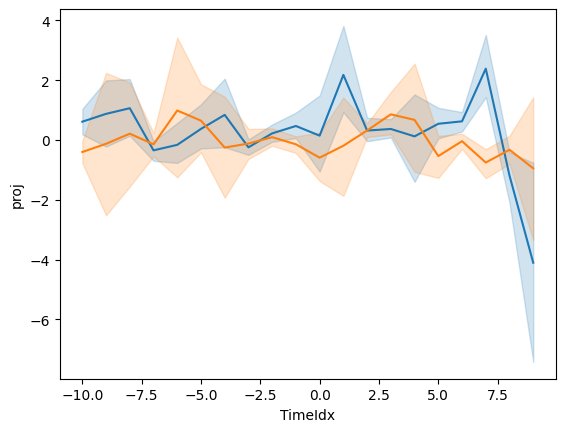

In [7]:
fig, ax = plt.subplots()
sns.lineplot(summed_proj, x="TimeIdx", y="proj", ax=ax)
sns.lineplot(shuffled_proj, x="TimeIdx", y="proj", ax=ax)


In [61]:
summed_proj[(summed_proj.TimeIdx >= 0) & (summed_proj.TimeIdx < 5)].mean()

TimeIdx                2.000000
PseudoTrialNumber    499.500000
proj                  -3.034889
dtype: float64

In [35]:
args.shuffle_idx = None
pref_vec = load_pref_vector(args)

In [39]:
pref_vec["std"].min()

3.6360051e-12

In [18]:
models = belief_partitions_io.read_models(args, [args.feat])

In [19]:
models.iloc[0].models.model.norm.running_var

tensor([3.1808e+01, 9.3085e+01, 1.2060e+01, 1.3221e-23, 9.1316e+01, 7.9825e+01,
        4.3674e+01, 2.4008e+02, 3.4463e+01, 4.1476e+01, 2.1879e+02, 8.7285e+01,
        8.4461e-04, 1.6864e+02, 5.1879e+01, 6.0736e+01, 1.2460e+02, 2.5769e+00,
        4.0906e+01, 7.5153e+00, 2.4540e+01, 2.5312e+01, 3.7983e+01, 1.0875e+01,
        3.4626e-01, 3.2968e+01, 2.1936e+00, 3.7082e+01, 1.4954e+00, 7.9734e-01,
        2.7359e+02, 3.8151e+00, 4.2926e+01, 5.5211e+00, 1.4442e+00, 1.4602e+02,
        6.4918e+00, 4.4131e+01, 3.2917e+01, 1.6424e+01, 2.1217e+01, 8.2761e-01,
        1.5027e+00, 2.0990e+02, 1.6758e+01, 7.1385e+01, 2.3394e+01, 7.3517e+00,
        2.4521e+00, 8.1689e-02, 4.7464e+00, 1.2949e-01, 8.7709e+00, 8.8447e+00,
        3.8924e+00, 2.6398e+02, 3.8933e+00, 1.2221e+01, 8.4576e+01, 2.9684e+01,
        1.0079e+01, 4.8158e+01, 5.1303e-08, 1.1743e+01, 9.7830e-01, 2.4473e+00,
        2.7827e+01, 1.5126e+02, 2.5221e+01, 1.7448e+02, 7.9108e+01, 2.7764e+01,
        2.5463e+01, 3.5686e+00, 1.0165e+